# ViT vs ResNet18 for Classifying Lens with and without CDM Substructure
This notebook shows the results for training and testing a Vision Transformer (based on the exact architecture given in [Transformers for Image Recognition at Scalehttps://arxiv.org/pdf/2010.11929.pdf) and a ResNet18 model which is pretrained on ImageNet. The lenses are simulated using PyHalo to add dark matter halos into those lenses with CDM substructure. The goal is to obtain a classifier that can classify images of lenses as to whether they have CDM substructure or not and we want to compare the two models.
An end goal would be to inform some type of network of the following equation:
\begin{equation}
\Delta g = |\tanh{\frac{1}{Q}\frac{\partial^2 \mathcal{F}}{\partial x \partial y}}|,
\end{equation}
where $Q$ is a normalisation constant and $\mathcal{F}$:
\begin{equation}
\mathcal{F} = \ln^{2n}\left(\frac{I_{0}}{I(x_{i},y_{i})}\right)\frac{R_{SER}^2}{b_{n}^{2n}},
\end{equation}
where $\mathcal{F}$ is a function of $(x_{i},y_{i})$.
We do not want to set $Q=max_{x_{i},y_{i}}(\Delta g)$, so we choose the upper quantile as the normalisation constant $Q$.

In the following, we load in the lens dataset, do some visualisation and define some useful functions that will initialise the dataloaders for the train/test datasets and save the results. We will first define the ResNet18 model and train that, then we will define the Vision Transformer, namely ViT, with our own implementation, and train it to obtain results. 
Finally we will compare the two models with their average losses over epochs and a ROCAUC plot.


In [1]:
# import required packages
import os
import torch
from torch import nn
from torch import Tensor
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from typing import Tuple, Union, List
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch import einsum
import torch.nn.functional as F 
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import warnings
from torchvision import models
from einops import rearrange, repeat 
from einops.layers.torch import Rearrange

In [2]:
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# path to working directory
# we'll start by opening the dataset
path = '/Users/ruby/Documents/Python Scripts/PhysicsInformedFeatures/DMSubstructure/Data/'

We'll load in the dataset, check how many samples for train and test we have an visualise.

In [3]:
# don't panic, I mis-named the label files and didn't bother to rename them
x_train = np.load(path+'data_train.npy')
y_train = np.load(path+'labels_test.npy')
x_test = np.load(path+'data_test.npy')
y_test = np.load(path+'labels_train.npy')

In [4]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

2000 2000
1000 1000


Let's have a look at these images.

In [5]:
# load in images and labels (from a smaller file so it doesn't take too long)
data_train = np.load(path+'Lens Data/X_train.npy')
label_train = np.load(path+'Lens Data/labels_train.npy')

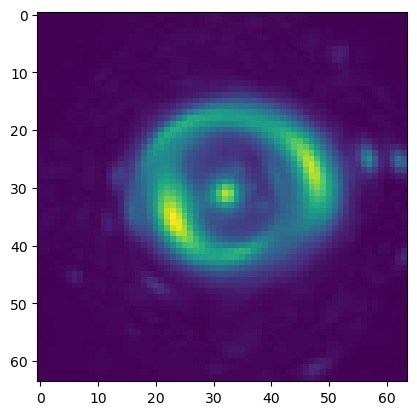

In [6]:
plt.imshow(data_train[0])

In [7]:
print(label_train[0])

[1 0]


Now, we'll define the dataloaders.

In [8]:
# initialise a dataloader
def get_dataloader(x, y, batch_size, mode):
    '''
    Creates a DataLoader object from numpy arrays containing the samples and 
    labels.

    Parameters
    ----------
    x : (numpy.ndarray)
        numpy array containing the proposed lensed images.
    y : (numpy.ndarray)
        numpy array containing the labels.
    batch_size : (int)
        size of the batches to be used in the DataLoader object.

    Returns
    -------
    DataLoader object

    '''
    x = torch.Tensor(np.array(x).reshape(len(x), 1, 64, 64))
    y = torch.Tensor(np.array(y))
    
    # create a TensorDataset object with the tensors and a DataLoader object
    if mode == 'train':
        # we can shuffle this dataset
        dataset = TensorDataset(x, y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    else:
        dataset = TensorDataset(x, y)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    return loader

trainloader = get_dataloader(x_train, y_train, batch_size=64, mode='train')
testloader = get_dataloader(x_test, y_test, batch_size=64, mode='test')

In [9]:
print(len(trainloader), len(testloader))

32 16


Let's have a look at one training sample.

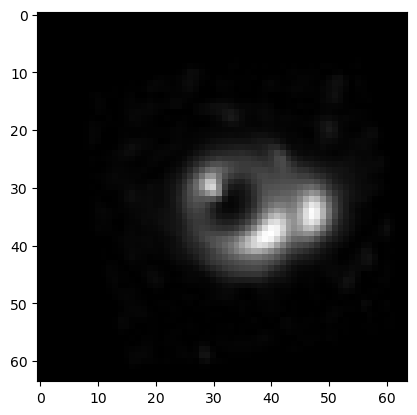

In [10]:
images, labels = next(iter(trainloader))
img = images[0].permute(2,1,0).numpy()
label = labels[0].numpy()
plt.imshow(img, cmap='gray')

In [11]:
print("For reference [1,0] is no cdm substructure and [0,1] is cdm substructure")
print(label)

For reference [1,0] is no cdm substructure and [0,1] is cdm substructure
[1. 0.]


Now we'll define some useful function to save the results and count the parameters of the models.

In [12]:
# function to save losses and useful parameters
import json
from typing import List
from sklearn.metrics import roc_curve, accuracy_score

def save_tofile(file_path, num_params, mean_loss_train, mean_f1_train, mean_loss_test, mean_f1_test, y_test_true, y_pred_prob):
    # calculate the fpr and tpr using sklearn's roc_curve
    fpr, tpr, _ = roc_curve(y_test_true, y_pred_prob)
    # calculate accuracy using scikit-learns' accuracy_score
    accuracy = accuracy_score(y_test_true, [1 if prob >= 0.5 else 0 for prob in y_pred_prob])
    
    # create a dictionary to hold the loss results, model size, ROC curve data, and the tpr and fpr.
    data_dict = {
        'model_size': num_params,
        'num_epochs': len(mean_loss_train),
        'mean_loss_train': mean_loss_train,
        'mean_f1_train': mean_f1_train,
        'mean_loss_test': mean_loss_test,
        'mean_f1_test': mean_f1_test,
        'y_test_true': y_test_true,
        'y_pred_prob': y_pred_prob,
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(),
        'accuracy': accuracy}
    
    try:
        # open a file in write mode
        with open(file_path, 'w') as f:
            # write the dictionary to the file as a JSON object
            json.dump(data_dict, f, indent=4)
    except IOError:
        print("An error occurred while writing the file")

In [13]:
# define a function to know the quantity of parameters in the model
def count_params(model):
    '''
    Count the total number of trainable parameters in a PyTorch model.

    Parameters
    ----------
    model : (nn.Module)
        The PyTorch model to count the parameters of.

    Returns
    -------
    num_params (int): The total number of trainable parameters the model has.

    '''
    # count the number of parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # we expect millions of parameters so convert this to orders of a million
    num_params = num_params/1e6
    
    print(f'The model has {num_params:.2f}M trainable parameters')
    
    return num_params

## Model Declaration - ResNet18
We'll use a pre-trained ResNet18 model with a few changes so it can take our single channel, two-class, dataset.

In [14]:
from torch import optim

In [15]:
# run this on the gpu
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

def get_model():
    # function to get the model 
    model = models.resnet18(pretrained=True) # pre-trained on ImageNet
    for param in model.parameters():
        param.requires_grad_ = False
    # change the first convolution layer to take a single channel input
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
    # change the pooling layer
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    # change the final output layer for a binary classification task
    model.fc = nn.Sequential(nn.Flatten(),
                             nn.Linear(512, 128),
                             nn.ReLU(),
                             nn.Dropout(0.2),
                             nn.Linear(128, 2),
                             )
    # use CrossEntropy loss for this is a binary classification task
    loss_fn = nn.CrossEntropyLoss()
    # use the Adam optimiser (similar to SGD) with standard learning rate.
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-4)
    return model.to(device), loss_fn, optimizer

In [16]:
net, loss_fn, optimizer = get_model()

/Users/ruby/miniconda3/envs/torch-night/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ruby/miniconda3/envs/torch-night/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Let's visualise a batch from the test dataset.

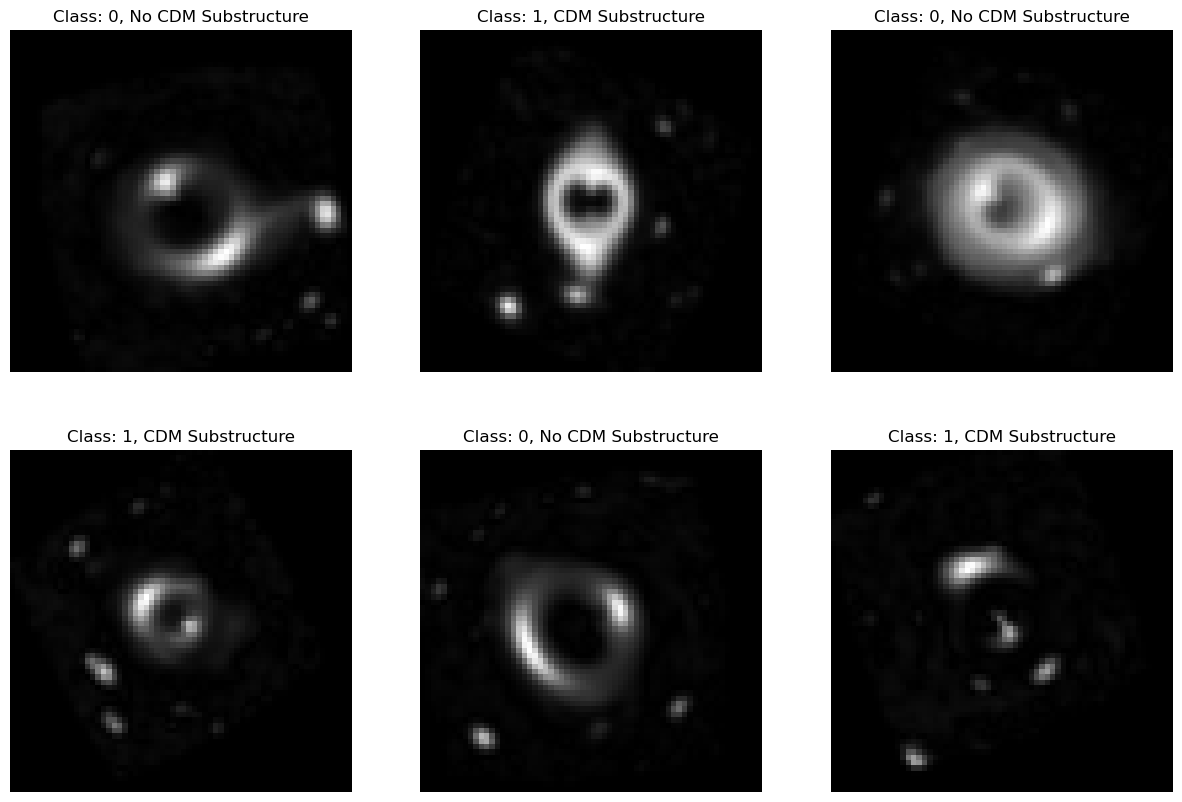

In [17]:
def visualise_dataset(model, n_images=6):
    imgs = 0
    fig = plt.figure(figsize=(15, 10))
    # get a test batch
    for i, data in enumerate(testloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.to(device), labels.to(device)
        # plot the images with their corresponding labels
        for j in range(inputs.size(0)):
            imgs += 1
            ax = plt.subplot(2, n_images//2, imgs)
            ax.axis('off')
            ax.set_title('Class: {}, {}'.format(int(sum(labels[j].cpu().numpy())) if labels[j].cpu().numpy()[1]==1 else 0,
                                               "CDM Substructure" if labels[j].cpu().numpy()[1]==1 else "No CDM Substructure"))
            ax.imshow(inputs[j].cpu().permute(2, 1, 0).numpy(), cmap='gray')
            if imgs == n_images:
                return
plt.ion()
visualise_dataset(net)
plt.ioff()

They look nice :)
Now, let's train ResNet18.

In [18]:
from sklearn.metrics import f1_score

# define parameters for training along with initialising empty lists to store the losses
n_epochs = 1000
print_every = 10
valid_loss_min = np.Inf
val_loss = []
train_loss = []
total_step = len(trainloader)
model_outputs = []
model_labels = []

mean_loss_train = []
mean_f1_train = []
mean_loss_test = []
mean_f1_test = []

train_loss2 = []
train_f1 = []
test_loss2 = []
test_f1 = []

# start training loop
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    total = 0
    print(f'Epoch {epoch}\n')
    # get a training batch
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        
        # store inputs and labels on the gpu
        inputs, labels = inputs.to(device), labels.to(device)
        # pass the input images to the model
        outputs = net(inputs)
        # compute the loss
        loss = loss_fn(outputs, labels)
        # back propagate
        loss.backward()
        # avoid exploding gradients here
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        # use internally stored gradients values to update tensors 
        optimizer.step()
        # get the loss
        train_loss2.append(loss.item())
        # reset gradients of optimised tensors
        optimizer.zero_grad()
        running_loss += loss.item()
        # get predictions
        _, pred = torch.max(outputs, dim=1)
        total += labels.size(0)
        
        # compute the ROC score
        preds = outputs.detach().cpu().numpy()  # detach the model's outputs from the graph
        targets = labels.detach().cpu().numpy() # detach the labels from the model's graph
        
        preds = [np.argmax(pred) for pred in preds] # get the max value along single dimension
        targets = [np.argmax(target) for target in targets]
        train_f1.append(f1_score(targets, preds, average='micro')) # compute the train f1 score
        
        # print training metrics
        if (batch_idx) % 20 == 0:
            print('Epoch [{}/{}], Step [{},{}], Loss: {:.4f}'.format(epoch, n_epochs, batch_idx, total_step, loss))
    train_loss.append(running_loss/total_step)
    print(f'\ntrain_loss: {np.mean(train_loss):.4f}')
    batch_loss = 0
    total_t = 0
    # turn off gradients for test mode
    with torch.no_grad():
        # put the model in evaluation mode
        net.eval()
        # get a test batch and proceed in the same thod as for training but without back propagation
        for inputs_t, labels_t in testloader:
            inputs_t, labels_t = inputs_t.to(device), labels_t.to(device)
            outputs_t = net(inputs_t)
            loss_t = loss_fn(outputs_t, labels_t)
            batch_loss += loss_t.item()
            _, pred_t = torch.max(outputs_t, dim=1)
            
            # compute the ROC curve
            preds = outputs_t.detach().cpu().numpy()
            targets = labels_t.detach().cpu().numpy()
            
            preds = [np.argmax(pred) for pred in preds]
            targets = [np.argmax(target) for target in targets]
            test_f1.append(f1_score(targets, preds, average='micro'))
            
            total_t += labels_t.size(0)
            
            y_pred_onehot = outputs_t.detach().cpu().numpy()
            y_true_onehot = labels_t.detach().cpu().numpy()
            y_test_true = np.argmax(y_true_onehot, axis=1)
            y_pred_prob = y_pred_onehot[:,1]
            y_test_true = y_test_true.tolist()
            y_pred_prob = y_pred_prob.tolist()
            
            model_outputs.append(outputs_t.detach().cpu().numpy())
            model_labels.append(labels_t.detach().cpu().numpy())
            
        val_loss.append(batch_loss/len(testloader))
        network_learned = batch_loss < valid_loss_min
        print(f'Validation loss: {np.mean(val_loss):.4f}\n')
    
        # save the best model parameters
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet18.pt')
            print('Improvement detected, saved model')
    
    # append the mean train loss and mean test loss to the list of losses
    mean_loss_train.append(np.mean(train_loss2))
    mean_f1_train.append(np.mean(train_f1))
    mean_loss_test.append(np.mean(test_loss2))
    mean_f1_test.append(np.mean(test_f1))
    net.train()

Epoch 1

Epoch [1/1000], Step [0,32], Loss: 0.7265
Epoch [1/1000], Step [20,32], Loss: 0.7572

train_loss: 0.7170
Validation loss: 0.6937

Improvement detected, saved model
Epoch 2

Epoch [2/1000], Step [0,32], Loss: 0.6725
Epoch [2/1000], Step [20,32], Loss: 0.6643

train_loss: 0.7007
Validation loss: 0.6823

Improvement detected, saved model
Epoch 3

Epoch [3/1000], Step [0,32], Loss: 0.6725
Epoch [3/1000], Step [20,32], Loss: 0.6559

train_loss: 0.6858
Validation loss: 0.6696

Improvement detected, saved model
Epoch 4

Epoch [4/1000], Step [0,32], Loss: 0.7180
Epoch [4/1000], Step [20,32], Loss: 0.7006

train_loss: 0.6771
Validation loss: 0.6589

Improvement detected, saved model
Epoch 5

Epoch [5/1000], Step [0,32], Loss: 0.5944
Epoch [5/1000], Step [20,32], Loss: 0.6666

train_loss: 0.6703
Validation loss: 0.6506

Improvement detected, saved model
Epoch 6

Epoch [6/1000], Step [0,32], Loss: 0.5905
Epoch [6/1000], Step [20,32], Loss: 0.6577

train_loss: 0.6646
Validation loss: 0.64

Epoch [48/1000], Step [20,32], Loss: 0.4264

train_loss: 0.5406
Validation loss: 0.5023

Improvement detected, saved model
Epoch 49

Epoch [49/1000], Step [0,32], Loss: 0.4260
Epoch [49/1000], Step [20,32], Loss: 0.4189

train_loss: 0.5382
Validation loss: 0.4995

Improvement detected, saved model
Epoch 50

Epoch [50/1000], Step [0,32], Loss: 0.4013
Epoch [50/1000], Step [20,32], Loss: 0.3825

train_loss: 0.5359
Validation loss: 0.4967

Improvement detected, saved model
Epoch 51

Epoch [51/1000], Step [0,32], Loss: 0.3777
Epoch [51/1000], Step [20,32], Loss: 0.4389

train_loss: 0.5336
Validation loss: 0.4939

Improvement detected, saved model
Epoch 52

Epoch [52/1000], Step [0,32], Loss: 0.4329
Epoch [52/1000], Step [20,32], Loss: 0.4452

train_loss: 0.5313
Validation loss: 0.4911

Improvement detected, saved model
Epoch 53

Epoch [53/1000], Step [0,32], Loss: 0.3602
Epoch [53/1000], Step [20,32], Loss: 0.4130

train_loss: 0.5292
Validation loss: 0.4884

Improvement detected, saved mod

Epoch [97/1000], Step [20,32], Loss: 0.2860

train_loss: 0.4361
Validation loss: 0.3781

Improvement detected, saved model
Epoch 98

Epoch [98/1000], Step [0,32], Loss: 0.2243
Epoch [98/1000], Step [20,32], Loss: 0.2314

train_loss: 0.4341
Validation loss: 0.3759

Improvement detected, saved model
Epoch 99

Epoch [99/1000], Step [0,32], Loss: 0.3256
Epoch [99/1000], Step [20,32], Loss: 0.1744

train_loss: 0.4323
Validation loss: 0.3738

Improvement detected, saved model
Epoch 100

Epoch [100/1000], Step [0,32], Loss: 0.2477
Epoch [100/1000], Step [20,32], Loss: 0.2816

train_loss: 0.4305
Validation loss: 0.3717

Improvement detected, saved model
Epoch 101

Epoch [101/1000], Step [0,32], Loss: 0.2772
Epoch [101/1000], Step [20,32], Loss: 0.2414

train_loss: 0.4288
Validation loss: 0.3696

Improvement detected, saved model
Epoch 102

Epoch [102/1000], Step [0,32], Loss: 0.1899
Epoch [102/1000], Step [20,32], Loss: 0.2571

train_loss: 0.4270
Validation loss: 0.3675

Improvement detected, 

Epoch [147/1000], Step [20,32], Loss: 0.1223

train_loss: 0.3564
Validation loss: 0.2879

Epoch 148

Epoch [148/1000], Step [0,32], Loss: 0.1276
Epoch [148/1000], Step [20,32], Loss: 0.1370

train_loss: 0.3551
Validation loss: 0.2864

Improvement detected, saved model
Epoch 149

Epoch [149/1000], Step [0,32], Loss: 0.1527
Epoch [149/1000], Step [20,32], Loss: 0.1417

train_loss: 0.3537
Validation loss: 0.2849

Improvement detected, saved model
Epoch 150

Epoch [150/1000], Step [0,32], Loss: 0.1184
Epoch [150/1000], Step [20,32], Loss: 0.1402

train_loss: 0.3523
Validation loss: 0.2835

Improvement detected, saved model
Epoch 151

Epoch [151/1000], Step [0,32], Loss: 0.1455
Epoch [151/1000], Step [20,32], Loss: 0.1296

train_loss: 0.3509
Validation loss: 0.2821

Epoch 152

Epoch [152/1000], Step [0,32], Loss: 0.2004
Epoch [152/1000], Step [20,32], Loss: 0.1799

train_loss: 0.3496
Validation loss: 0.2806

Improvement detected, saved model
Epoch 153

Epoch [153/1000], Step [0,32], Loss: 0


train_loss: 0.2970
Validation loss: 0.2259

Epoch 199

Epoch [199/1000], Step [0,32], Loss: 0.1195
Epoch [199/1000], Step [20,32], Loss: 0.0983

train_loss: 0.2960
Validation loss: 0.2249

Improvement detected, saved model
Epoch 200

Epoch [200/1000], Step [0,32], Loss: 0.1319
Epoch [200/1000], Step [20,32], Loss: 0.0940

train_loss: 0.2950
Validation loss: 0.2240

Epoch 201

Epoch [201/1000], Step [0,32], Loss: 0.1106
Epoch [201/1000], Step [20,32], Loss: 0.1343

train_loss: 0.2940
Validation loss: 0.2230

Improvement detected, saved model
Epoch 202

Epoch [202/1000], Step [0,32], Loss: 0.0874
Epoch [202/1000], Step [20,32], Loss: 0.0960

train_loss: 0.2931
Validation loss: 0.2220

Epoch 203

Epoch [203/1000], Step [0,32], Loss: 0.0615
Epoch [203/1000], Step [20,32], Loss: 0.0852

train_loss: 0.2921
Validation loss: 0.2210

Epoch 204

Epoch [204/1000], Step [0,32], Loss: 0.0493
Epoch [204/1000], Step [20,32], Loss: 0.0801

train_loss: 0.2911
Validation loss: 0.2201

Epoch 205

Epoch 

Validation loss: 0.1830

Epoch 251

Epoch [251/1000], Step [0,32], Loss: 0.1202
Epoch [251/1000], Step [20,32], Loss: 0.1500

train_loss: 0.2515
Validation loss: 0.1823

Epoch 252

Epoch [252/1000], Step [0,32], Loss: 0.0404
Epoch [252/1000], Step [20,32], Loss: 0.0630

train_loss: 0.2508
Validation loss: 0.1816

Improvement detected, saved model
Epoch 253

Epoch [253/1000], Step [0,32], Loss: 0.0558
Epoch [253/1000], Step [20,32], Loss: 0.0529

train_loss: 0.2501
Validation loss: 0.1809

Improvement detected, saved model
Epoch 254

Epoch [254/1000], Step [0,32], Loss: 0.0544
Epoch [254/1000], Step [20,32], Loss: 0.0281

train_loss: 0.2493
Validation loss: 0.1803

Epoch 255

Epoch [255/1000], Step [0,32], Loss: 0.1094
Epoch [255/1000], Step [20,32], Loss: 0.0777

train_loss: 0.2486
Validation loss: 0.1796

Improvement detected, saved model
Epoch 256

Epoch [256/1000], Step [0,32], Loss: 0.0540
Epoch [256/1000], Step [20,32], Loss: 0.0639

train_loss: 0.2480
Validation loss: 0.1790

Epo

Epoch [303/1000], Step [20,32], Loss: 0.0254

train_loss: 0.2183
Validation loss: 0.1524

Epoch 304

Epoch [304/1000], Step [0,32], Loss: 0.0158
Epoch [304/1000], Step [20,32], Loss: 0.0250

train_loss: 0.2178
Validation loss: 0.1519

Epoch 305

Epoch [305/1000], Step [0,32], Loss: 0.0511
Epoch [305/1000], Step [20,32], Loss: 0.0685

train_loss: 0.2173
Validation loss: 0.1514

Epoch 306

Epoch [306/1000], Step [0,32], Loss: 0.0207
Epoch [306/1000], Step [20,32], Loss: 0.0348

train_loss: 0.2167
Validation loss: 0.1509

Improvement detected, saved model
Epoch 307

Epoch [307/1000], Step [0,32], Loss: 0.0542
Epoch [307/1000], Step [20,32], Loss: 0.0347

train_loss: 0.2162
Validation loss: 0.1505

Improvement detected, saved model
Epoch 308

Epoch [308/1000], Step [0,32], Loss: 0.0405
Epoch [308/1000], Step [20,32], Loss: 0.0134

train_loss: 0.2157
Validation loss: 0.1500

Epoch 309

Epoch [309/1000], Step [0,32], Loss: 0.0185
Epoch [309/1000], Step [20,32], Loss: 0.0559

train_loss: 0.21

Epoch [356/1000], Step [20,32], Loss: 0.0217

train_loss: 0.1929
Validation loss: 0.1302

Epoch 357

Epoch [357/1000], Step [0,32], Loss: 0.0634
Epoch [357/1000], Step [20,32], Loss: 0.0834

train_loss: 0.1925
Validation loss: 0.1299

Epoch 358

Epoch [358/1000], Step [0,32], Loss: 0.0205
Epoch [358/1000], Step [20,32], Loss: 0.0157

train_loss: 0.1920
Validation loss: 0.1295

Improvement detected, saved model
Epoch 359

Epoch [359/1000], Step [0,32], Loss: 0.0231
Epoch [359/1000], Step [20,32], Loss: 0.0301

train_loss: 0.1916
Validation loss: 0.1292

Epoch 360

Epoch [360/1000], Step [0,32], Loss: 0.0253
Epoch [360/1000], Step [20,32], Loss: 0.0165

train_loss: 0.1912
Validation loss: 0.1288

Improvement detected, saved model
Epoch 361

Epoch [361/1000], Step [0,32], Loss: 0.0224
Epoch [361/1000], Step [20,32], Loss: 0.0411

train_loss: 0.1907
Validation loss: 0.1285

Epoch 362

Epoch [362/1000], Step [0,32], Loss: 0.0109
Epoch [362/1000], Step [20,32], Loss: 0.0251

train_loss: 0.19

Epoch [411/1000], Step [20,32], Loss: 0.0457

train_loss: 0.1720
Validation loss: 0.1130

Epoch 412

Epoch [412/1000], Step [0,32], Loss: 0.0092
Epoch [412/1000], Step [20,32], Loss: 0.0263

train_loss: 0.1716
Validation loss: 0.1128

Epoch 413

Epoch [413/1000], Step [0,32], Loss: 0.0299
Epoch [413/1000], Step [20,32], Loss: 0.0167

train_loss: 0.1712
Validation loss: 0.1125

Epoch 414

Epoch [414/1000], Step [0,32], Loss: 0.0133
Epoch [414/1000], Step [20,32], Loss: 0.0112

train_loss: 0.1710
Validation loss: 0.1122

Epoch 415

Epoch [415/1000], Step [0,32], Loss: 0.0084
Epoch [415/1000], Step [20,32], Loss: 0.0200

train_loss: 0.1706
Validation loss: 0.1120

Epoch 416

Epoch [416/1000], Step [0,32], Loss: 0.0269
Epoch [416/1000], Step [20,32], Loss: 0.0395

train_loss: 0.1703
Validation loss: 0.1117

Epoch 417

Epoch [417/1000], Step [0,32], Loss: 0.0085
Epoch [417/1000], Step [20,32], Loss: 0.0226

train_loss: 0.1700
Validation loss: 0.1114

Epoch 418

Epoch [418/1000], Step [0,32]

Epoch [465/1000], Step [20,32], Loss: 0.0100

train_loss: 0.1555
Validation loss: 0.1000

Epoch 466

Epoch [466/1000], Step [0,32], Loss: 0.0092
Epoch [466/1000], Step [20,32], Loss: 0.0285

train_loss: 0.1552
Validation loss: 0.0998

Epoch 467

Epoch [467/1000], Step [0,32], Loss: 0.0162
Epoch [467/1000], Step [20,32], Loss: 0.0138

train_loss: 0.1549
Validation loss: 0.0996

Epoch 468

Epoch [468/1000], Step [0,32], Loss: 0.0097
Epoch [468/1000], Step [20,32], Loss: 0.0189

train_loss: 0.1546
Validation loss: 0.0994

Improvement detected, saved model
Epoch 469

Epoch [469/1000], Step [0,32], Loss: 0.0188
Epoch [469/1000], Step [20,32], Loss: 0.0114

train_loss: 0.1544
Validation loss: 0.0992

Epoch 470

Epoch [470/1000], Step [0,32], Loss: 0.0202
Epoch [470/1000], Step [20,32], Loss: 0.0084

train_loss: 0.1541
Validation loss: 0.0989

Epoch 471

Epoch [471/1000], Step [0,32], Loss: 0.0117
Epoch [471/1000], Step [20,32], Loss: 0.0439

train_loss: 0.1538
Validation loss: 0.0987

Epoch 


train_loss: 0.1420
Validation loss: 0.0896

Epoch 520

Epoch [520/1000], Step [0,32], Loss: 0.0369
Epoch [520/1000], Step [20,32], Loss: 0.0068

train_loss: 0.1417
Validation loss: 0.0895

Epoch 521

Epoch [521/1000], Step [0,32], Loss: 0.0702
Epoch [521/1000], Step [20,32], Loss: 0.0759

train_loss: 0.1415
Validation loss: 0.0893

Improvement detected, saved model
Epoch 522

Epoch [522/1000], Step [0,32], Loss: 0.0648
Epoch [522/1000], Step [20,32], Loss: 0.1236

train_loss: 0.1413
Validation loss: 0.0891

Epoch 523

Epoch [523/1000], Step [0,32], Loss: 0.0256
Epoch [523/1000], Step [20,32], Loss: 0.0081

train_loss: 0.1411
Validation loss: 0.0890

Epoch 524

Epoch [524/1000], Step [0,32], Loss: 0.0206
Epoch [524/1000], Step [20,32], Loss: 0.0376

train_loss: 0.1409
Validation loss: 0.0888

Epoch 525

Epoch [525/1000], Step [0,32], Loss: 0.0577
Epoch [525/1000], Step [20,32], Loss: 0.0131

train_loss: 0.1406
Validation loss: 0.0886

Epoch 526

Epoch [526/1000], Step [0,32], Loss: 0.0

Epoch [574/1000], Step [20,32], Loss: 0.0577

train_loss: 0.1307
Validation loss: 0.0811

Epoch 575

Epoch [575/1000], Step [0,32], Loss: 0.0251
Epoch [575/1000], Step [20,32], Loss: 0.0066

train_loss: 0.1305
Validation loss: 0.0809

Epoch 576

Epoch [576/1000], Step [0,32], Loss: 0.0023
Epoch [576/1000], Step [20,32], Loss: 0.0059

train_loss: 0.1303
Validation loss: 0.0808

Epoch 577

Epoch [577/1000], Step [0,32], Loss: 0.0068
Epoch [577/1000], Step [20,32], Loss: 0.0044

train_loss: 0.1301
Validation loss: 0.0807

Epoch 578

Epoch [578/1000], Step [0,32], Loss: 0.0128
Epoch [578/1000], Step [20,32], Loss: 0.0039

train_loss: 0.1300
Validation loss: 0.0805

Epoch 579

Epoch [579/1000], Step [0,32], Loss: 0.0189
Epoch [579/1000], Step [20,32], Loss: 0.0085

train_loss: 0.1298
Validation loss: 0.0804

Epoch 580

Epoch [580/1000], Step [0,32], Loss: 0.0675
Epoch [580/1000], Step [20,32], Loss: 0.1018

train_loss: 0.1296
Validation loss: 0.0802

Improvement detected, saved model
Epoch 

Validation loss: 0.0741

Improvement detected, saved model
Epoch 629

Epoch [629/1000], Step [0,32], Loss: 0.0037
Epoch [629/1000], Step [20,32], Loss: 0.0009

train_loss: 0.1213
Validation loss: 0.0740

Improvement detected, saved model
Epoch 630

Epoch [630/1000], Step [0,32], Loss: 0.0107
Epoch [630/1000], Step [20,32], Loss: 0.0027

train_loss: 0.1211
Validation loss: 0.0739

Epoch 631

Epoch [631/1000], Step [0,32], Loss: 0.0018
Epoch [631/1000], Step [20,32], Loss: 0.0037

train_loss: 0.1210
Validation loss: 0.0738

Epoch 632

Epoch [632/1000], Step [0,32], Loss: 0.0070
Epoch [632/1000], Step [20,32], Loss: 0.0026

train_loss: 0.1208
Validation loss: 0.0737

Epoch 633

Epoch [633/1000], Step [0,32], Loss: 0.0032
Epoch [633/1000], Step [20,32], Loss: 0.0196

train_loss: 0.1207
Validation loss: 0.0735

Epoch 634

Epoch [634/1000], Step [0,32], Loss: 0.0016
Epoch [634/1000], Step [20,32], Loss: 0.0145

train_loss: 0.1205
Validation loss: 0.0734

Epoch 635

Epoch [635/1000], Step [0,

Validation loss: 0.0683

Improvement detected, saved model
Epoch 683

Epoch [683/1000], Step [0,32], Loss: 0.0062
Epoch [683/1000], Step [20,32], Loss: 0.0133

train_loss: 0.1133
Validation loss: 0.0682

Epoch 684

Epoch [684/1000], Step [0,32], Loss: 0.0020
Epoch [684/1000], Step [20,32], Loss: 0.0020

train_loss: 0.1132
Validation loss: 0.0681

Epoch 685

Epoch [685/1000], Step [0,32], Loss: 0.0108
Epoch [685/1000], Step [20,32], Loss: 0.0055

train_loss: 0.1130
Validation loss: 0.0680

Epoch 686

Epoch [686/1000], Step [0,32], Loss: 0.0023
Epoch [686/1000], Step [20,32], Loss: 0.0133

train_loss: 0.1129
Validation loss: 0.0679

Epoch 687

Epoch [687/1000], Step [0,32], Loss: 0.0065
Epoch [687/1000], Step [20,32], Loss: 0.0152

train_loss: 0.1127
Validation loss: 0.0678

Epoch 688

Epoch [688/1000], Step [0,32], Loss: 0.0036
Epoch [688/1000], Step [20,32], Loss: 0.0346

train_loss: 0.1127
Validation loss: 0.0677

Epoch 689

Epoch [689/1000], Step [0,32], Loss: 0.0012
Epoch [689/1000]


train_loss: 0.1063
Validation loss: 0.0632

Epoch 738

Epoch [738/1000], Step [0,32], Loss: 0.0071
Epoch [738/1000], Step [20,32], Loss: 0.0026

train_loss: 0.1062
Validation loss: 0.0631

Epoch 739

Epoch [739/1000], Step [0,32], Loss: 0.0101
Epoch [739/1000], Step [20,32], Loss: 0.0124

train_loss: 0.1061
Validation loss: 0.0630

Epoch 740

Epoch [740/1000], Step [0,32], Loss: 0.0051
Epoch [740/1000], Step [20,32], Loss: 0.0477

train_loss: 0.1060
Validation loss: 0.0629

Improvement detected, saved model
Epoch 741

Epoch [741/1000], Step [0,32], Loss: 0.0465
Epoch [741/1000], Step [20,32], Loss: 0.0512

train_loss: 0.1059
Validation loss: 0.0628

Epoch 742

Epoch [742/1000], Step [0,32], Loss: 0.0240
Epoch [742/1000], Step [20,32], Loss: 0.0224

train_loss: 0.1058
Validation loss: 0.0627

Epoch 743

Epoch [743/1000], Step [0,32], Loss: 0.0106
Epoch [743/1000], Step [20,32], Loss: 0.0090

train_loss: 0.1056
Validation loss: 0.0627

Epoch 744

Epoch [744/1000], Step [0,32], Loss: 0.0


train_loss: 0.1002
Validation loss: 0.0588

Epoch 793

Epoch [793/1000], Step [0,32], Loss: 0.0068
Epoch [793/1000], Step [20,32], Loss: 0.0024

train_loss: 0.1001
Validation loss: 0.0587

Epoch 794

Epoch [794/1000], Step [0,32], Loss: 0.0033
Epoch [794/1000], Step [20,32], Loss: 0.0043

train_loss: 0.1000
Validation loss: 0.0586

Epoch 795

Epoch [795/1000], Step [0,32], Loss: 0.0018
Epoch [795/1000], Step [20,32], Loss: 0.0387

train_loss: 0.0999
Validation loss: 0.0586

Epoch 796

Epoch [796/1000], Step [0,32], Loss: 0.0033
Epoch [796/1000], Step [20,32], Loss: 0.0044

train_loss: 0.0998
Validation loss: 0.0585

Epoch 797

Epoch [797/1000], Step [0,32], Loss: 0.0013
Epoch [797/1000], Step [20,32], Loss: 0.0046

train_loss: 0.0997
Validation loss: 0.0584

Epoch 798

Epoch [798/1000], Step [0,32], Loss: 0.0015
Epoch [798/1000], Step [20,32], Loss: 0.0038

train_loss: 0.0996
Validation loss: 0.0583

Epoch 799

Epoch [799/1000], Step [0,32], Loss: 0.0035
Epoch [799/1000], Step [20,32]

Epoch [848/1000], Step [20,32], Loss: 0.0057

train_loss: 0.0948
Validation loss: 0.0549

Epoch 849

Epoch [849/1000], Step [0,32], Loss: 0.0016
Epoch [849/1000], Step [20,32], Loss: 0.0014

train_loss: 0.0947
Validation loss: 0.0548

Epoch 850

Epoch [850/1000], Step [0,32], Loss: 0.0195
Epoch [850/1000], Step [20,32], Loss: 0.0055

train_loss: 0.0946
Validation loss: 0.0548

Epoch 851

Epoch [851/1000], Step [0,32], Loss: 0.0066
Epoch [851/1000], Step [20,32], Loss: 0.0019

train_loss: 0.0945
Validation loss: 0.0547

Epoch 852

Epoch [852/1000], Step [0,32], Loss: 0.0005
Epoch [852/1000], Step [20,32], Loss: 0.0352

train_loss: 0.0944
Validation loss: 0.0546

Epoch 853

Epoch [853/1000], Step [0,32], Loss: 0.0012
Epoch [853/1000], Step [20,32], Loss: 0.0006

train_loss: 0.0943
Validation loss: 0.0546

Epoch 854

Epoch [854/1000], Step [0,32], Loss: 0.0010
Epoch [854/1000], Step [20,32], Loss: 0.0348

train_loss: 0.0942
Validation loss: 0.0545

Epoch 855

Epoch [855/1000], Step [0,32]

Epoch [904/1000], Step [20,32], Loss: 0.0018

train_loss: 0.0898
Validation loss: 0.0515

Epoch 905

Epoch [905/1000], Step [0,32], Loss: 0.0039
Epoch [905/1000], Step [20,32], Loss: 0.0037

train_loss: 0.0897
Validation loss: 0.0514

Epoch 906

Epoch [906/1000], Step [0,32], Loss: 0.0014
Epoch [906/1000], Step [20,32], Loss: 0.0063

train_loss: 0.0896
Validation loss: 0.0514

Epoch 907

Epoch [907/1000], Step [0,32], Loss: 0.0524
Epoch [907/1000], Step [20,32], Loss: 0.0137

train_loss: 0.0896
Validation loss: 0.0513

Epoch 908

Epoch [908/1000], Step [0,32], Loss: 0.0019
Epoch [908/1000], Step [20,32], Loss: 0.0011

train_loss: 0.0895
Validation loss: 0.0513

Epoch 909

Epoch [909/1000], Step [0,32], Loss: 0.0009
Epoch [909/1000], Step [20,32], Loss: 0.0067

train_loss: 0.0894
Validation loss: 0.0512

Epoch 910

Epoch [910/1000], Step [0,32], Loss: 0.0010
Epoch [910/1000], Step [20,32], Loss: 0.0049

train_loss: 0.0893
Validation loss: 0.0512

Epoch 911

Epoch [911/1000], Step [0,32]

Epoch [960/1000], Step [20,32], Loss: 0.0243

train_loss: 0.0855
Validation loss: 0.0485

Epoch 961

Epoch [961/1000], Step [0,32], Loss: 0.0097
Epoch [961/1000], Step [20,32], Loss: 0.0011

train_loss: 0.0854
Validation loss: 0.0484

Epoch 962

Epoch [962/1000], Step [0,32], Loss: 0.0075
Epoch [962/1000], Step [20,32], Loss: 0.0006

train_loss: 0.0854
Validation loss: 0.0484

Epoch 963

Epoch [963/1000], Step [0,32], Loss: 0.0016
Epoch [963/1000], Step [20,32], Loss: 0.0015

train_loss: 0.0853
Validation loss: 0.0483

Epoch 964

Epoch [964/1000], Step [0,32], Loss: 0.0002
Epoch [964/1000], Step [20,32], Loss: 0.0014

train_loss: 0.0852
Validation loss: 0.0483

Epoch 965

Epoch [965/1000], Step [0,32], Loss: 0.0015
Epoch [965/1000], Step [20,32], Loss: 0.0003

train_loss: 0.0851
Validation loss: 0.0482

Epoch 966

Epoch [966/1000], Step [0,32], Loss: 0.0034
Epoch [966/1000], Step [20,32], Loss: 0.0010

train_loss: 0.0851
Validation loss: 0.0482

Epoch 967

Epoch [967/1000], Step [0,32]

Probably should have sent this to the gpu.. well we can see the model layers here:

In [19]:
net.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Count the model parameters:


In [20]:
num_parameters = count_params(net)

The model has 11.24M trainable parameters


And save the results.

In [21]:
# save results 
results_path = '/Users/ruby/Documents/Python Scripts/PhysicsInformedFeatures/Models/Results/'
json_path = os.path.join(results_path, 'resnet18.json')

save_tofile(json_path, num_parameters, mean_loss_train, mean_f1_train, mean_loss_test, mean_f1_test, y_test_true, y_pred_prob)


Let's visualise the same images from the test set as before but this time with the model's predictions.

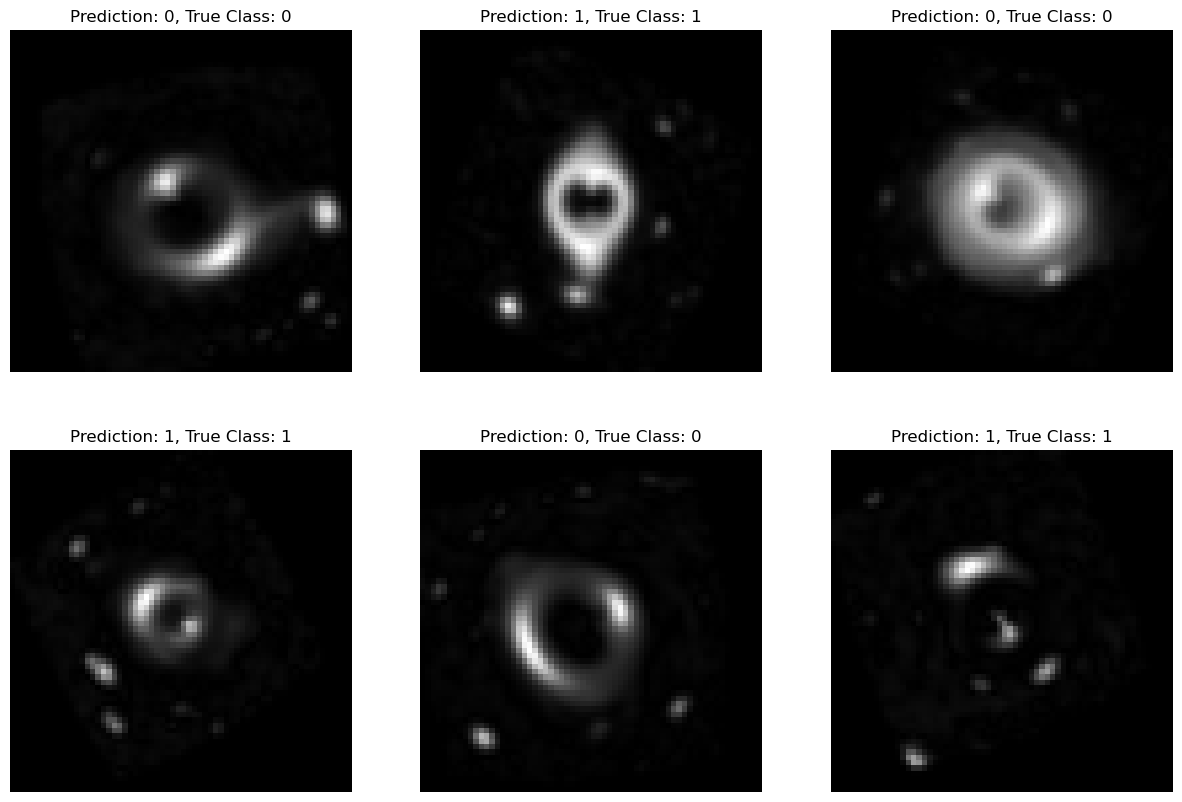

In [45]:
# visualising the predictions made by the model
def visualise_model(net, n_images=6):
    imgs = 0
    fig = plt.figure(figsize=(15, 10))
    # get test batch
    for i, data in enumerate(testloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.to(device), labels.to(device)
        # make predictions with the model
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        # convert to numpy array from torch.Tensor
        preds = preds.cpu().numpy() if device else preds.numpy()
        # plot the images and predictions labelled with their true class
        for j in range(inputs.size(0)):
            imgs += 1
            ax = plt.subplot(2, n_images//2, imgs)
            ax.axis('off')
            ax.set_title('Prediction: {}, True Class: {}'.format(preds[j], int(sum(labels[j].cpu().numpy())) if labels[j].cpu().numpy()[1]==1 else 0))
            ax.imshow(inputs[j].permute(2, 1, 0).cpu().numpy(), cmap='gray')
            if imgs == n_images:
                return
            
plt.ion()
visualise_model(net)
plt.ioff()

Looks good. Already from above, we can see that the ResNet18 predicted 6/6 lenses correctly with their appropriate class.

## Model Declaration - ViT (Vision Transformer)
Now, we'll define the Vision Transformer class and train it with the same training set as for ResNet18 before evaulation on the test set and saving the results. 

ViT (from my understanding) is composed of a FeedForward network with Attention blocks that are alternated in the Transformer block, so, we'll start by defining the FeedForward network.

### FeedForward

In [23]:
# helper function to get image sizes
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# Initialise the FeedForward class
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),   # layer normalisation 
            nn.Linear(dim, hidden_dim), # fully-connected layer dependent on no. layers and no. hidden layers
            nn.GELU(), # GELU activation function (Gaussian Error Linear Unit to weight input by percentile rather than their sign)
            nn.Dropout(dropout), # no dropout here
            nn.Linear(hidden_dim, dim), # fully-connected 
            nn.Dropout(dropout) # again no dropout
            )
    
    # define the forward function 
    def forward(self, x):
        # just pass through the network 
        return self.net(x)

### Attention

In [24]:
# define the attention blocks
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)
        
        self.heads = heads
        self.scale = dim_head ** (-0.5)
        
        self.norm = nn.LayerNorm(dim)
        
        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
            ) if project_out else nn.Identity()
        
    def forward(self, x):
        x = self.norm(x)
        
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.heads), qkv)
        
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        
        attn = self.attend(dots)
        attn = self.dropout(attn)
        
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

### Transformer Block

In [25]:
# define the transformer block that stacks layers of attention and feedforward
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout),
                FeedForward(dim, mlp_dim, dropout=dropout)
                ]))
            
    def forward(self, x):
        for attn, ff in self.layers:
            # attention layer + original input
            x = attn(x) + x
            # feedforward layer + input
            x = ff(x) + x
        # normalise over the layer
        return self.norm(x)

### ViT
Now we'll put these three blocks together and define the Vision Transformer model itself as described in [AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/pdf/2010.11929.pdf).

In [26]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim,
                 pool='cls', channels=3, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        # get dimensions of the input images
        image_height, image_width = pair(image_size)
        # get the patch size which should be a multiple of image_size
        patch_height, patch_width = pair(patch_size)
        
        # make sure that the image dimensions are divisible by the patch dimensions
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by patch size'
        
        # get the number of images patches and the dimensionality of the patches
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        
        # reshape input tensors to the correct patch sizes
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim))
        
        # apply positional embedding such that each patch takes a unique value
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        # classification token: represents the inputs for the classification task (based on BERT from paper)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        # apply the transformer block
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        
        self.pool = pool
        self.to_latent = nn.Identity()
        # pass to standard multi-layer perceptron
        self.mlp_head = nn.Linear(dim, num_classes)
        
    def forward(self, img):
        # get the patches
        x = self.to_patch_embedding(img)
        # get patch size such that we can create a representation of the input for the classification task
        b, n, _ = x.shape
        # classification token
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        # represent with original input
        x = torch.cat((cls_tokens, x), dim=1)
        # add unique positional embedding parameter
        x += self.pos_embedding[:, :(n+1)]
        x = self.dropout(x)
        # apply transformer block
        x = self.transformer(x)
        # take the mean otherwise take the argument of the label
        x = x.mean(dim=1) if self.pool == 'mean' else x[:,0]
        x = self.to_latent(x)
        # apply multi-layer perceptron to final output
        return self.mlp_head(x)

Now, we'll initialise the model with defined training parameters.

In [27]:
# model training settings
vit = ViT(
    image_size=64,
    patch_size=32,
    num_classes=2,
    dim=1024,
    depth=2,
    heads=24,
    mlp_dim=16,
    dropout=0.1,
    channels=1,
    emb_dropout=0.1,
    pool='cls')

We'll state the device, loss function and optimiser to use for training.

In [28]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# use CrossEntropy loss again for binary classification tasks
loss_fn = nn.CrossEntropyLoss()
# use AdamW optimiser with a very small learning rate 
optimizer = torch.optim.AdamW(vit.parameters(), lr=5e-7)

Here, we choose the *AdamW* optimiser. How is that different from *Adam*?

*AdamW*, which is another modification of SGD, modifies the typical weight decay implementation of *Adam* by adjusting the weight decay term to appear in the gradient update. So, not much different but worth a try.

Let's visualise the model.

In [29]:
vit.to(device)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-1): 2 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.1, inplace=False)
          (to_qkv): Linear(in_features=1024, out_features=4608, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=1536, out_features=1024, bias=True)
            (1): Dropout(p=0.1, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
     

And count the number of model parameters.

In [30]:
num_params = count_params(vit)

The model has 13.72M trainable parameters


Wow, so ViT has roughly 2.5M more parameters than ResNet18.

Define a function to train ViT with, similar to the training of ResNet18.

In [31]:
# define a training loop function
def train_model(model, trainloader, testloader, n_epochs, optimizer, loss_fn, device):
    '''
    Training loop for PyTorch model.

    Parameters
    ----------
    model : (nn.Module)
        the model to be trained.
    trainloader : (DataLoader)
        DataLoader containing the training set.
    testloader : (DataLoader)
        DataLoader containing the test set.
    n_epochs : (int)
        number of training epochs.
    optimizer : (optim.Optimizer)
        optimisation algorithm to use for training.
    loss_fn : (nn.Module)
        the loss function to use for training.
    device : (str)
        device to run the model on.

    Returns
    -------
    - mean_loss_train (list): mean loss per epoch for the training set.
    - mean_auc_test (list): mean ROCAUC per epoch for the test set.

    '''
    # initialise lists to keep track on metrics
    mean_loss_train = []
    mean_f1_train = []
    mean_loss_test = []
    mean_f1_test = []
    
    # loop over epochs
    for i in range(n_epochs):
        
        # initlise lists to keep track of training loss
        train_loss = []
        train_f1 = []
        
        # set model to train
        model.train()
        
        # loop over the training data
        for images, labels in trainloader:
            # move data to the device
            images, labels = images.to(device), labels.to(device)
            
            # zero the gradients
            optimizer.zero_grad()
            
            # make the forward pass
            outputs = model(images)
            
            # compute the loss
            loss = loss_fn(outputs, labels)
          
            
            # make the backward pass and optimise
            loss.backward()
            optimizer.step()
            
            # append the loss to train_loss list
            train_loss.append(loss.item())
            
            # compute the ROC score
            preds = outputs.detach().cpu().numpy()
            targets = labels.detach().cpu().numpy()
            
            preds = [np.argmax(pred) for pred in preds]
            targets = [np.argmax(target) for target in targets]
            train_f1.append(f1_score(targets, preds, average='micro'))
        
        # initlise lists to keep track of the test loss
        test_loss = []
        test_f1 = []
        
        # set the model to eval mode
        model.eval()
        
        # turn off the gradients for evaluation mode
        with torch.no_grad():
            
            # loop over test data
            for images, labels in testloader:
                # move data to the device
                images, labels = images.to(device), labels.to(device)
                
                # make the forward pass
                outputs = model(images)
                # calculate the loss
                loss = loss_fn(outputs, labels)
                # append the loss to test_loss list
                test_loss.append(loss.item())
                
                # compute the ROC score
                preds = outputs.detach().cpu().numpy()
                targets = labels.detach().cpu().numpy()
                
                preds = [np.argmax(pred for pred in preds)]
                targets = [np.argmax(target for target in targets)]
                test_f1.append(f1_score(targets, preds, average='micro'))
        
        # append the mean train loss to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        mean_f1_train.append(np.mean(train_f1))
        mean_loss_test.append(np.mean(test_loss))
        mean_f1_test.append(np.mean(test_f1))
        
        #print the epoch metrics
        print(f'Epoch {i}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train F1: {mean_f1_train[-1]:.4f}, Test Loss: {mean_loss_test[-1]:.4f}, Test F1: {mean_f1_test[-1]:.4f}')
        
    # return lists of mean train loss and mean test loss
    return mean_loss_train, mean_f1_train, mean_loss_test, mean_f1_test

And we'll train.



In [32]:
mean_loss_train_vit, mean_f1_train_vit, mean_loss_test_vit, mean_f1_test_vit = train_model(vit, trainloader, testloader,
                                                                                           1000, optimizer=optimizer,
                                                                                           loss_fn=loss_fn, device=device)

Epoch 0/1000, Train Loss: 0.8078, Train F1: 0.5015, Test Loss: 0.7746, Test F1: 1.0000
Epoch 1/1000, Train Loss: 0.7525, Train F1: 0.5024, Test Loss: 0.7266, Test F1: 1.0000
Epoch 2/1000, Train Loss: 0.7254, Train F1: 0.5005, Test Loss: 0.6983, Test F1: 1.0000
Epoch 3/1000, Train Loss: 0.7008, Train F1: 0.5278, Test Loss: 0.6814, Test F1: 1.0000
Epoch 4/1000, Train Loss: 0.6880, Train F1: 0.5352, Test Loss: 0.6724, Test F1: 1.0000
Epoch 5/1000, Train Loss: 0.6789, Train F1: 0.5674, Test Loss: 0.6668, Test F1: 1.0000
Epoch 6/1000, Train Loss: 0.6784, Train F1: 0.5669, Test Loss: 0.6628, Test F1: 1.0000
Epoch 7/1000, Train Loss: 0.6692, Train F1: 0.6060, Test Loss: 0.6591, Test F1: 1.0000
Epoch 8/1000, Train Loss: 0.6713, Train F1: 0.5786, Test Loss: 0.6557, Test F1: 1.0000
Epoch 9/1000, Train Loss: 0.6661, Train F1: 0.5981, Test Loss: 0.6526, Test F1: 1.0000
Epoch 10/1000, Train Loss: 0.6608, Train F1: 0.6040, Test Loss: 0.6497, Test F1: 1.0000
Epoch 11/1000, Train Loss: 0.6532, Train F

Epoch 94/1000, Train Loss: 0.5958, Train F1: 0.6680, Test Loss: 0.5878, Test F1: 1.0000
Epoch 95/1000, Train Loss: 0.5973, Train F1: 0.6616, Test Loss: 0.5872, Test F1: 1.0000
Epoch 96/1000, Train Loss: 0.5898, Train F1: 0.6777, Test Loss: 0.5872, Test F1: 1.0000
Epoch 97/1000, Train Loss: 0.5943, Train F1: 0.6685, Test Loss: 0.5859, Test F1: 1.0000
Epoch 98/1000, Train Loss: 0.5880, Train F1: 0.6714, Test Loss: 0.5849, Test F1: 1.0000
Epoch 99/1000, Train Loss: 0.5905, Train F1: 0.6802, Test Loss: 0.5853, Test F1: 1.0000
Epoch 100/1000, Train Loss: 0.5862, Train F1: 0.6836, Test Loss: 0.5845, Test F1: 1.0000
Epoch 101/1000, Train Loss: 0.5865, Train F1: 0.6758, Test Loss: 0.5835, Test F1: 1.0000
Epoch 102/1000, Train Loss: 0.5919, Train F1: 0.6675, Test Loss: 0.5827, Test F1: 1.0000
Epoch 103/1000, Train Loss: 0.5954, Train F1: 0.6670, Test Loss: 0.5825, Test F1: 1.0000
Epoch 104/1000, Train Loss: 0.5896, Train F1: 0.6777, Test Loss: 0.5817, Test F1: 1.0000
Epoch 105/1000, Train Loss:

Epoch 187/1000, Train Loss: 0.5380, Train F1: 0.7271, Test Loss: 0.5267, Test F1: 1.0000
Epoch 188/1000, Train Loss: 0.5333, Train F1: 0.7314, Test Loss: 0.5265, Test F1: 1.0000
Epoch 189/1000, Train Loss: 0.5258, Train F1: 0.7324, Test Loss: 0.5253, Test F1: 1.0000
Epoch 190/1000, Train Loss: 0.5362, Train F1: 0.7148, Test Loss: 0.5258, Test F1: 1.0000
Epoch 191/1000, Train Loss: 0.5255, Train F1: 0.7207, Test Loss: 0.5237, Test F1: 1.0000
Epoch 192/1000, Train Loss: 0.5368, Train F1: 0.7290, Test Loss: 0.5240, Test F1: 1.0000
Epoch 193/1000, Train Loss: 0.5237, Train F1: 0.7373, Test Loss: 0.5229, Test F1: 1.0000
Epoch 194/1000, Train Loss: 0.5335, Train F1: 0.7305, Test Loss: 0.5230, Test F1: 1.0000
Epoch 195/1000, Train Loss: 0.5309, Train F1: 0.7148, Test Loss: 0.5222, Test F1: 1.0000
Epoch 196/1000, Train Loss: 0.5310, Train F1: 0.7207, Test Loss: 0.5211, Test F1: 1.0000
Epoch 197/1000, Train Loss: 0.5289, Train F1: 0.7305, Test Loss: 0.5198, Test F1: 1.0000
Epoch 198/1000, Train

Epoch 280/1000, Train Loss: 0.4803, Train F1: 0.7632, Test Loss: 0.4733, Test F1: 1.0000
Epoch 281/1000, Train Loss: 0.4799, Train F1: 0.7583, Test Loss: 0.4728, Test F1: 1.0000
Epoch 282/1000, Train Loss: 0.4787, Train F1: 0.7568, Test Loss: 0.4731, Test F1: 1.0000
Epoch 283/1000, Train Loss: 0.4825, Train F1: 0.7612, Test Loss: 0.4721, Test F1: 1.0000
Epoch 284/1000, Train Loss: 0.4811, Train F1: 0.7588, Test Loss: 0.4727, Test F1: 1.0000
Epoch 285/1000, Train Loss: 0.4788, Train F1: 0.7686, Test Loss: 0.4714, Test F1: 1.0000
Epoch 286/1000, Train Loss: 0.4763, Train F1: 0.7681, Test Loss: 0.4715, Test F1: 1.0000
Epoch 287/1000, Train Loss: 0.4746, Train F1: 0.7671, Test Loss: 0.4705, Test F1: 1.0000
Epoch 288/1000, Train Loss: 0.4808, Train F1: 0.7612, Test Loss: 0.4689, Test F1: 1.0000
Epoch 289/1000, Train Loss: 0.4811, Train F1: 0.7676, Test Loss: 0.4704, Test F1: 1.0000
Epoch 290/1000, Train Loss: 0.4747, Train F1: 0.7666, Test Loss: 0.4695, Test F1: 1.0000
Epoch 291/1000, Train

Epoch 373/1000, Train Loss: 0.4447, Train F1: 0.7788, Test Loss: 0.4274, Test F1: 1.0000
Epoch 374/1000, Train Loss: 0.4454, Train F1: 0.7783, Test Loss: 0.4281, Test F1: 1.0000
Epoch 375/1000, Train Loss: 0.4400, Train F1: 0.7905, Test Loss: 0.4268, Test F1: 1.0000
Epoch 376/1000, Train Loss: 0.4425, Train F1: 0.7793, Test Loss: 0.4270, Test F1: 1.0000
Epoch 377/1000, Train Loss: 0.4376, Train F1: 0.7896, Test Loss: 0.4284, Test F1: 1.0000
Epoch 378/1000, Train Loss: 0.4358, Train F1: 0.7886, Test Loss: 0.4258, Test F1: 1.0000
Epoch 379/1000, Train Loss: 0.4463, Train F1: 0.7798, Test Loss: 0.4260, Test F1: 1.0000
Epoch 380/1000, Train Loss: 0.4417, Train F1: 0.7812, Test Loss: 0.4263, Test F1: 1.0000
Epoch 381/1000, Train Loss: 0.4369, Train F1: 0.7886, Test Loss: 0.4264, Test F1: 1.0000
Epoch 382/1000, Train Loss: 0.4420, Train F1: 0.7837, Test Loss: 0.4257, Test F1: 1.0000
Epoch 383/1000, Train Loss: 0.4361, Train F1: 0.7871, Test Loss: 0.4237, Test F1: 1.0000
Epoch 384/1000, Train

Epoch 466/1000, Train Loss: 0.4116, Train F1: 0.8027, Test Loss: 0.3822, Test F1: 1.0000
Epoch 467/1000, Train Loss: 0.4056, Train F1: 0.8179, Test Loss: 0.3834, Test F1: 1.0000
Epoch 468/1000, Train Loss: 0.4092, Train F1: 0.7988, Test Loss: 0.3840, Test F1: 1.0000
Epoch 469/1000, Train Loss: 0.4065, Train F1: 0.8018, Test Loss: 0.3827, Test F1: 1.0000
Epoch 470/1000, Train Loss: 0.4121, Train F1: 0.8203, Test Loss: 0.3806, Test F1: 1.0000
Epoch 471/1000, Train Loss: 0.4088, Train F1: 0.8086, Test Loss: 0.3826, Test F1: 1.0000
Epoch 472/1000, Train Loss: 0.3960, Train F1: 0.8164, Test Loss: 0.3820, Test F1: 1.0000
Epoch 473/1000, Train Loss: 0.4068, Train F1: 0.8125, Test Loss: 0.3811, Test F1: 1.0000
Epoch 474/1000, Train Loss: 0.4027, Train F1: 0.8066, Test Loss: 0.3804, Test F1: 1.0000
Epoch 475/1000, Train Loss: 0.4022, Train F1: 0.8208, Test Loss: 0.3792, Test F1: 1.0000
Epoch 476/1000, Train Loss: 0.4071, Train F1: 0.8164, Test Loss: 0.3804, Test F1: 1.0000
Epoch 477/1000, Train

Epoch 559/1000, Train Loss: 0.3766, Train F1: 0.8276, Test Loss: 0.3388, Test F1: 1.0000
Epoch 560/1000, Train Loss: 0.3698, Train F1: 0.8296, Test Loss: 0.3388, Test F1: 1.0000
Epoch 561/1000, Train Loss: 0.3749, Train F1: 0.8320, Test Loss: 0.3369, Test F1: 1.0000
Epoch 562/1000, Train Loss: 0.3734, Train F1: 0.8276, Test Loss: 0.3376, Test F1: 1.0000
Epoch 563/1000, Train Loss: 0.3652, Train F1: 0.8413, Test Loss: 0.3371, Test F1: 1.0000
Epoch 564/1000, Train Loss: 0.3707, Train F1: 0.8354, Test Loss: 0.3378, Test F1: 1.0000
Epoch 565/1000, Train Loss: 0.3727, Train F1: 0.8286, Test Loss: 0.3350, Test F1: 1.0000
Epoch 566/1000, Train Loss: 0.3589, Train F1: 0.8433, Test Loss: 0.3350, Test F1: 1.0000
Epoch 567/1000, Train Loss: 0.3630, Train F1: 0.8477, Test Loss: 0.3353, Test F1: 1.0000
Epoch 568/1000, Train Loss: 0.3636, Train F1: 0.8374, Test Loss: 0.3351, Test F1: 1.0000
Epoch 569/1000, Train Loss: 0.3574, Train F1: 0.8394, Test Loss: 0.3351, Test F1: 1.0000
Epoch 570/1000, Train

Epoch 652/1000, Train Loss: 0.3345, Train F1: 0.8608, Test Loss: 0.2940, Test F1: 1.0000
Epoch 653/1000, Train Loss: 0.3363, Train F1: 0.8501, Test Loss: 0.2920, Test F1: 1.0000
Epoch 654/1000, Train Loss: 0.3308, Train F1: 0.8589, Test Loss: 0.2932, Test F1: 1.0000
Epoch 655/1000, Train Loss: 0.3274, Train F1: 0.8623, Test Loss: 0.2915, Test F1: 1.0000
Epoch 656/1000, Train Loss: 0.3376, Train F1: 0.8550, Test Loss: 0.2906, Test F1: 1.0000
Epoch 657/1000, Train Loss: 0.3371, Train F1: 0.8481, Test Loss: 0.2927, Test F1: 1.0000
Epoch 658/1000, Train Loss: 0.3394, Train F1: 0.8560, Test Loss: 0.2920, Test F1: 1.0000
Epoch 659/1000, Train Loss: 0.3302, Train F1: 0.8555, Test Loss: 0.2890, Test F1: 1.0000
Epoch 660/1000, Train Loss: 0.3271, Train F1: 0.8652, Test Loss: 0.2897, Test F1: 1.0000
Epoch 661/1000, Train Loss: 0.3298, Train F1: 0.8608, Test Loss: 0.2900, Test F1: 1.0000
Epoch 662/1000, Train Loss: 0.3315, Train F1: 0.8516, Test Loss: 0.2885, Test F1: 1.0000
Epoch 663/1000, Train

Epoch 745/1000, Train Loss: 0.2948, Train F1: 0.8740, Test Loss: 0.2486, Test F1: 1.0000
Epoch 746/1000, Train Loss: 0.2910, Train F1: 0.8823, Test Loss: 0.2489, Test F1: 1.0000
Epoch 747/1000, Train Loss: 0.2958, Train F1: 0.8804, Test Loss: 0.2474, Test F1: 1.0000
Epoch 748/1000, Train Loss: 0.2923, Train F1: 0.8813, Test Loss: 0.2479, Test F1: 1.0000
Epoch 749/1000, Train Loss: 0.2959, Train F1: 0.8701, Test Loss: 0.2475, Test F1: 1.0000
Epoch 750/1000, Train Loss: 0.2838, Train F1: 0.8853, Test Loss: 0.2466, Test F1: 1.0000
Epoch 751/1000, Train Loss: 0.2972, Train F1: 0.8716, Test Loss: 0.2460, Test F1: 1.0000
Epoch 752/1000, Train Loss: 0.2994, Train F1: 0.8770, Test Loss: 0.2478, Test F1: 1.0000
Epoch 753/1000, Train Loss: 0.3113, Train F1: 0.8613, Test Loss: 0.2452, Test F1: 1.0000
Epoch 754/1000, Train Loss: 0.2965, Train F1: 0.8730, Test Loss: 0.2438, Test F1: 1.0000
Epoch 755/1000, Train Loss: 0.2869, Train F1: 0.8828, Test Loss: 0.2441, Test F1: 1.0000
Epoch 756/1000, Train

Epoch 838/1000, Train Loss: 0.2610, Train F1: 0.8965, Test Loss: 0.2058, Test F1: 1.0000
Epoch 839/1000, Train Loss: 0.2734, Train F1: 0.8896, Test Loss: 0.2051, Test F1: 1.0000
Epoch 840/1000, Train Loss: 0.2679, Train F1: 0.8921, Test Loss: 0.2045, Test F1: 1.0000
Epoch 841/1000, Train Loss: 0.2675, Train F1: 0.8921, Test Loss: 0.2047, Test F1: 1.0000
Epoch 842/1000, Train Loss: 0.2605, Train F1: 0.9009, Test Loss: 0.2038, Test F1: 1.0000
Epoch 843/1000, Train Loss: 0.2718, Train F1: 0.8921, Test Loss: 0.2036, Test F1: 1.0000
Epoch 844/1000, Train Loss: 0.2543, Train F1: 0.9033, Test Loss: 0.2027, Test F1: 1.0000
Epoch 845/1000, Train Loss: 0.2553, Train F1: 0.8994, Test Loss: 0.2031, Test F1: 1.0000
Epoch 846/1000, Train Loss: 0.2656, Train F1: 0.8877, Test Loss: 0.2018, Test F1: 1.0000
Epoch 847/1000, Train Loss: 0.2617, Train F1: 0.8896, Test Loss: 0.2020, Test F1: 1.0000
Epoch 848/1000, Train Loss: 0.2655, Train F1: 0.8916, Test Loss: 0.2023, Test F1: 1.0000
Epoch 849/1000, Train

Epoch 931/1000, Train Loss: 0.2213, Train F1: 0.9131, Test Loss: 0.1668, Test F1: 1.0000
Epoch 932/1000, Train Loss: 0.2305, Train F1: 0.9028, Test Loss: 0.1665, Test F1: 1.0000
Epoch 933/1000, Train Loss: 0.2275, Train F1: 0.9116, Test Loss: 0.1658, Test F1: 1.0000
Epoch 934/1000, Train Loss: 0.2276, Train F1: 0.9048, Test Loss: 0.1648, Test F1: 1.0000
Epoch 935/1000, Train Loss: 0.2415, Train F1: 0.9023, Test Loss: 0.1654, Test F1: 1.0000
Epoch 936/1000, Train Loss: 0.2499, Train F1: 0.8975, Test Loss: 0.1655, Test F1: 1.0000
Epoch 937/1000, Train Loss: 0.2239, Train F1: 0.9097, Test Loss: 0.1638, Test F1: 1.0000
Epoch 938/1000, Train Loss: 0.2277, Train F1: 0.9116, Test Loss: 0.1638, Test F1: 1.0000
Epoch 939/1000, Train Loss: 0.2333, Train F1: 0.9023, Test Loss: 0.1636, Test F1: 1.0000
Epoch 940/1000, Train Loss: 0.2366, Train F1: 0.9067, Test Loss: 0.1631, Test F1: 1.0000
Epoch 941/1000, Train Loss: 0.2392, Train F1: 0.9102, Test Loss: 0.1624, Test F1: 1.0000
Epoch 942/1000, Train

Nice. Clearly, we should ignore the test F1 score.
Now we'll want to save these results and prepare a ROCAUC curve with the test dataset.

In [33]:
vit_json_path = os.path.join(results_path, 'vit.json')

# prepare test dataset for ROCAUC curve
final_testloader = get_dataloader(x_test, y_test, batch_size=1000, mode='test')
# store the data on the gpu
for imgs, targets in final_testloader:
    imgs, targets = imgs.to(device), targets.to(device)
    break

# put the model in evaluation mode and get the predictions
vit.eval()
output = vit(imgs)
y_pred_onehot_vit = output.detach().cpu().numpy()  # detach from model's graph
y_true_onehot_vit = targets.detach().cpu().numpy() # detach from model's graph

# get the probabilities and convert to a label format
y_test_true_vit = np.argmax(y_true_onehot_vit, axis=1)
# get the predicted probabilities for the positive class
y_pred_prob_vit = y_pred_onehot_vit[:,1]

y_test_true_vit = y_test_true_vit.tolist()
y_pred_prob_vit = y_pred_prob_vit.tolist()

# and now save
save_tofile(vit_json_path, num_params, mean_loss_train_vit, mean_f1_train_vit, mean_loss_test_vit, mean_f1_test_vit, y_test_true_vit, y_pred_prob_vit)


In [34]:
num_params

13.724706

### Comparing the two models
Now that we've trained and saved the results from both of the models, we want to do a result comparison.
We'll start by loading in the saved results for the two models.

In [36]:
# function to load .json files
def load(path, filename):
    file = path+filename
    with open(file) as f:
        data = json.load(f)
    return data

# get the results for ResNet18 and ViT
vit_json = load(path=results_path, filename='vit.json')
resnet18_json = load(path=results_path, filename='resnet18.json')

Let's check this.

In [37]:
print(vit_json['model_size'])
print(resnet18_json['model_size'])

13.724706
11.236162


We'll plot a comparison of the losses for each model against epochs.

In [39]:
print(vit_json)

{'model_size': 13.724706, 'num_epochs': 1000, 'mean_loss_train': [0.8077544663101435, 0.7524619251489639, 0.7254350855946541, 0.7007504440844059, 0.6879919487982988, 0.6788511071354151, 0.6783503107726574, 0.6691720597445965, 0.6712628789246082, 0.6660549249500036, 0.66080417111516, 0.6532310228794813, 0.6625575497746468, 0.6574848461896181, 0.656479250639677, 0.6536245457828045, 0.64969970472157, 0.6462222002446651, 0.6497562360018492, 0.6431091483682394, 0.6437424588948488, 0.6368732322007418, 0.6360284127295017, 0.6337267179042101, 0.638487484306097, 0.6388666052371264, 0.6409478671848774, 0.6296583749353886, 0.6289935801178217, 0.6248953118920326, 0.6351054757833481, 0.6260396335273981, 0.6361492797732353, 0.6278822962194681, 0.6292604189366102, 0.6255720499902964, 0.6230031382292509, 0.6290188115090132, 0.6230485327541828, 0.6188341658562422, 0.6280108280479908, 0.6222592070698738, 0.6204893030226231, 0.6246419101953506, 0.6212454102933407, 0.6184603087604046, 0.6224743835628033, 

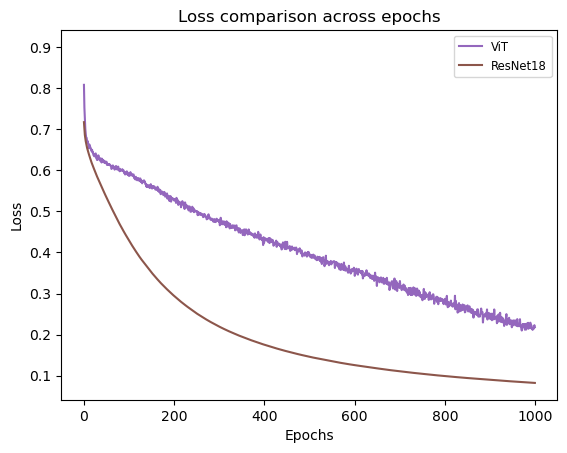

In [40]:
plt.plot([0], [0.9])
plt.plot([0], [0.9])

loss_vit = vit_json['mean_loss_train']
loss_resnet18 = resnet18_json['mean_loss_train']

plt.plot(loss_vit, label='ViT')
plt.plot(loss_resnet18, label='ResNet18')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss comparison across epochs')
plt.legend(fontsize='small')
plt.show()

Looks good. Surprisingly, ResNet18 is converging faster than ViT although ReNets18's training does start to plateau around 700 epochs whereas we can see that the Vision Transformer's loss is still converging at this point. It might be worth training both models again for more epochs (maybe 2000/3000). Now we want to make a comparison of the ROCAUC curves for each model and we'll do this in the next cell.

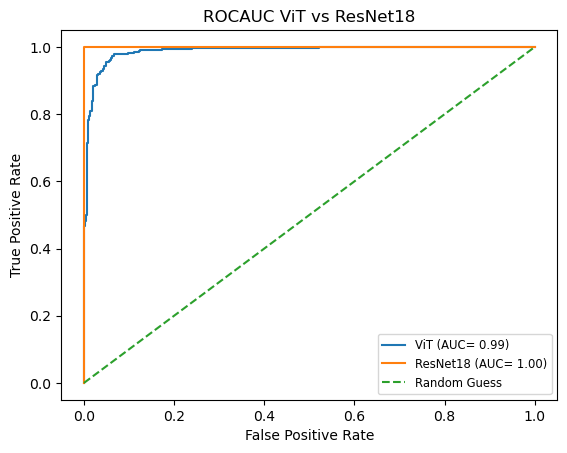

In [43]:
from sklearn.metrics import roc_curve, auc
import torch

ytrue_vit = vit_json['y_test_true']
yprob_vit = vit_json['y_pred_prob']
ytrue_resnet18 = resnet18_json['y_test_true']
yprob_resnet18 = resnet18_json['y_pred_prob']

fpr_vit, tpr_vit, _ = roc_curve(ytrue_vit, yprob_vit)
rocauc_vit = auc(fpr_vit, tpr_vit)
fpr_resnet18, tpr_resnet18, _ = roc_curve(ytrue_resnet18, yprob_resnet18)
rocauc_resnet18 = auc(fpr_resnet18, tpr_resnet18)

plt.plot(fpr_vit, tpr_vit, label=f'ViT (AUC= {rocauc_vit:.2f})')
plt.plot(fpr_resnet18, tpr_resnet18, label=f'ResNet18 (AUC= {rocauc_resnet18:.2f})')
plt.plot([0,1], [0,1], '--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROCAUC ViT vs ResNet18')
plt.legend(fontsize='small')
plt.show()

In [44]:
print(fpr_vit)

[0.    0.    0.    0.002 0.002 0.004 0.004 0.006 0.006 0.008 0.008 0.01
 0.01  0.012 0.012 0.014 0.014 0.018 0.018 0.02  0.02  0.024 0.024 0.026
 0.026 0.028 0.028 0.03  0.03  0.032 0.032 0.036 0.036 0.038 0.038 0.042
 0.042 0.044 0.044 0.046 0.046 0.048 0.048 0.054 0.054 0.056 0.056 0.058
 0.058 0.06  0.06  0.062 0.062 0.064 0.064 0.066 0.066 0.076 0.076 0.098
 0.098 0.112 0.112 0.122 0.122 0.124 0.124 0.14  0.14  0.174 0.174 0.24
 0.24  0.516 0.516 0.522 0.522 1.   ]


I highly doubt that ResNet18 is a perfect classifier so we should look into this. 